# Visualizing the mouse behavior

In [1]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
from sklearn import discriminant_analysis
from sklearn import model_selection
from sklearn import tree as Tree
import sklearn.tree
import sys
import os
%matplotlib inline 

## load in csv files (from running exportTrials.m)

In [2]:
data = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/new_master_8020_df.csv',index_col=0)

# p(switch) | switched in ith previous trial

In [42]:
p_switch = np.zeros(20)
for i in np.arange(0,20):
    p_switch[i] = data.iloc[np.where(data['Switch'].values == 1)[0]-i]['Switch'].mean(axis=0)

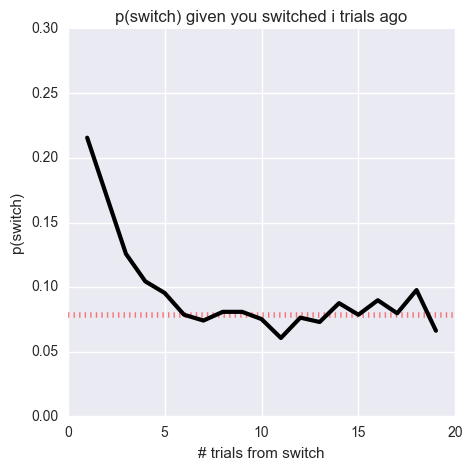

In [57]:
plt.figure(figsize=(5,5))
plt.plot(np.arange(1,20),p_switch[1:],linewidth=3,color='black')
plt.hlines(y=data['Switch'].mean(axis=0),xmin=0,xmax=20,color='red',alpha=0.5,linewidth=4,linestyles='dotted',label='average')
plt.ylim(0,0.3)
plt.title('p(switch) given you switched i trials ago')
plt.ylabel('p(switch)')
plt.xlabel('# trials from switch')